## Lesson 15:
### Exercise 1: A noisy detector

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns
c = sns.color_palette('rocket', 5)
%config InlineBackend.figure_format='retina'
plt.rcParams['figure.figsize'] = (5, 4)


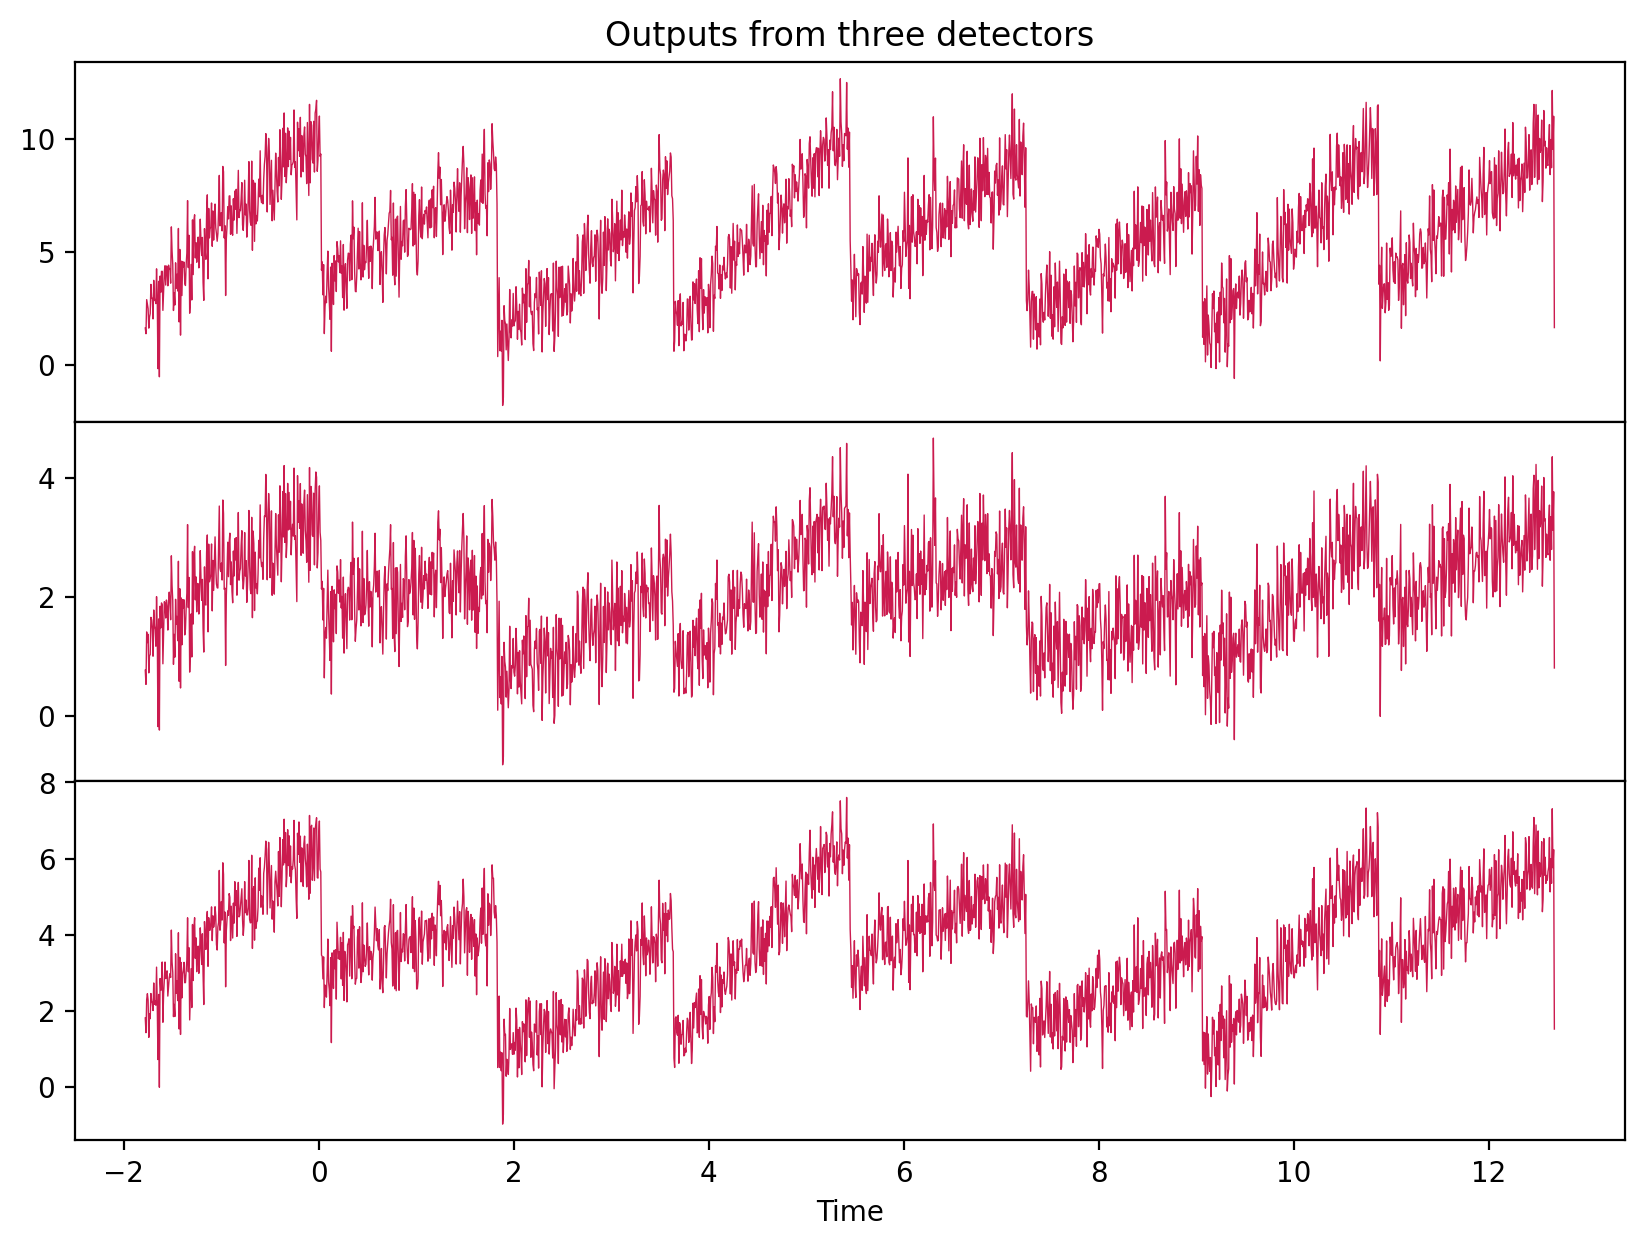

In [2]:
X=np.load('../../astrostatistics_bicocca_2023/solutions/noisydetector.npy')

time = np.linspace(X[:,0].min(), X[:,0].max(), X.shape[0])

fig, axs = plt.subplots(3,figsize=(10,7), sharex=True)
fig.subplots_adjust(hspace=0.)

for ax,s in zip(axs,X.T):
    ax.plot(time,s, color=c[2], lw=0.5)

axs[-1].set_xlabel('Time')
axs[0].set_title('Outputs from three detectors');


Our data in in the form: $3 \times 2000 = $ timeseries $\times$ features. Each timeseries consists of 2000 values. However, considering that our data originates from the observation of a *Cepheid star* with its intrinsic variability, we anticipate discovering that our data exhibits lower dimensionality.

This is the perfect playground for the application of dimensionality reduction techniques such as **Principle Component Analysis**.

In [3]:
from sklearn.decomposition import PCA

#----------------------------------------------------------------------
n_components = 4 # This means: mean + 4 other components

Let's visualize the effect of data standardization, which is mandatory for applying PCA.

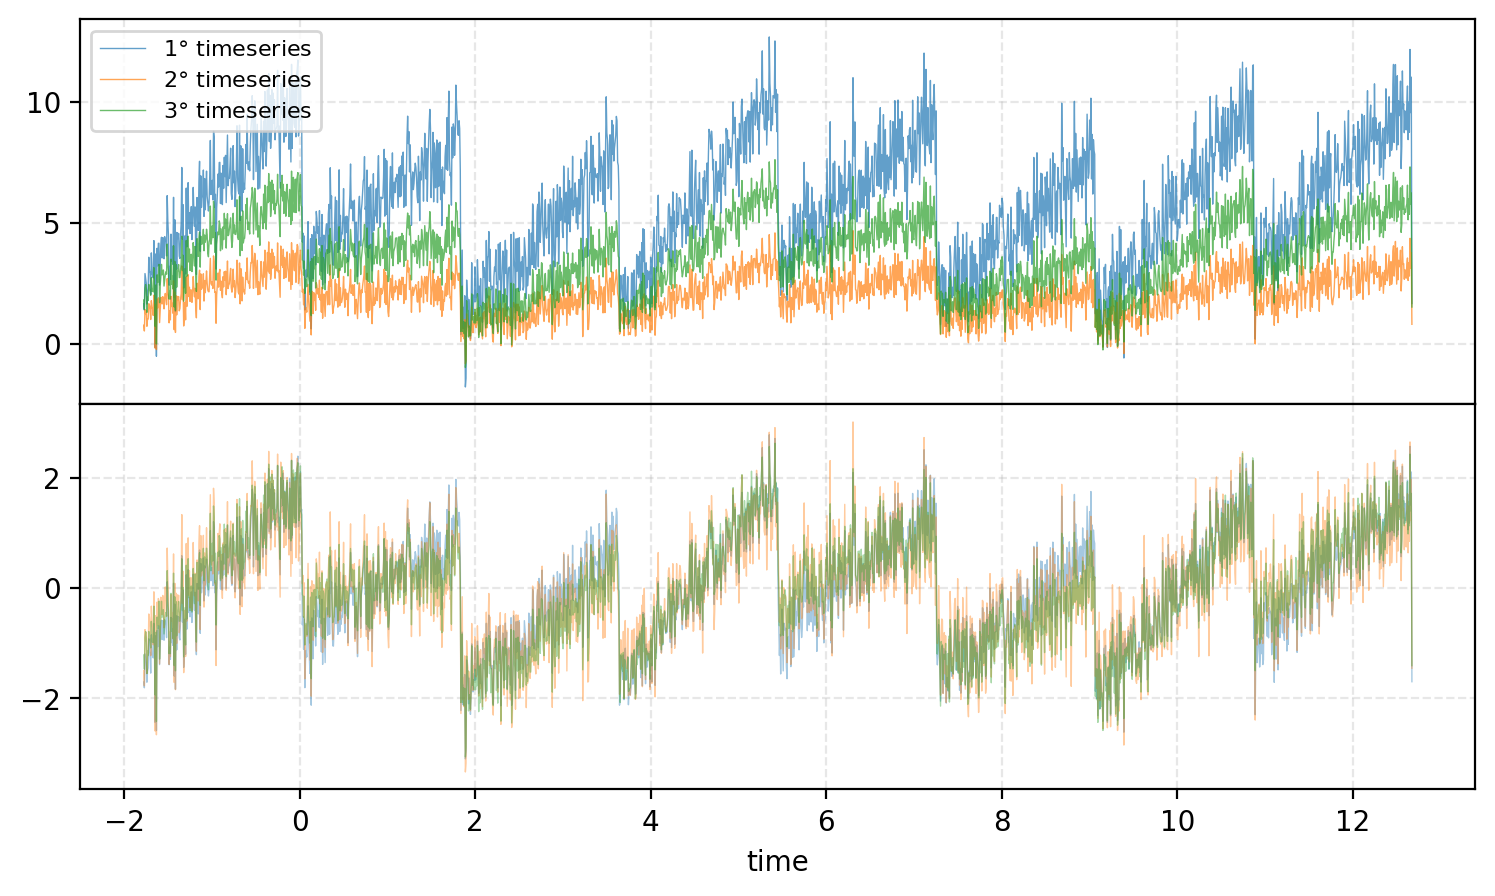

In [4]:
# First we standardize our data
from sklearn.preprocessing import StandardScaler
labels = [r'$1°$ timeseries', r'$2°$ timeseries', r'$3°$ timeseries']

scaler = StandardScaler()
std_X = scaler.fit_transform(X)
std_X_T = std_X.T
mean_X = np.mean(X, axis=1)

fig, ax = plt.subplots(2,1, figsize=(9,5), sharex=True)
fig.subplots_adjust(hspace=0.)

plt.subplot(211)
plt.plot(time, X, alpha=0.7, lw=0.5, label=labels);
plt.legend(fontsize=8);
plt.subplot(212)
plt.plot(time, std_X, alpha=0.4, lw=0.5);
plt.xlabel('time')

for _ in ax:
    _.grid(True, ls='--', alpha=0.3)

In [41]:
pca = PCA(n_components=0.995)
pca.fit(std_X)
print("{:d} features are needed to explain 99.5% of the variance".format(pca.n_components_))
X_pca = pca.transform(std_X)

# Eigenvalues:
evals = pca.explained_variance_ratio_ 

print('Explained fractional variance of data encapsulated in the eigenvalues: ' + str(evals))

3 features are needed to explain 99.5% of the variance
Explained fractional variance of data encapsulated in the eigenvalues: [0.96897533 0.01871181 0.01231286]


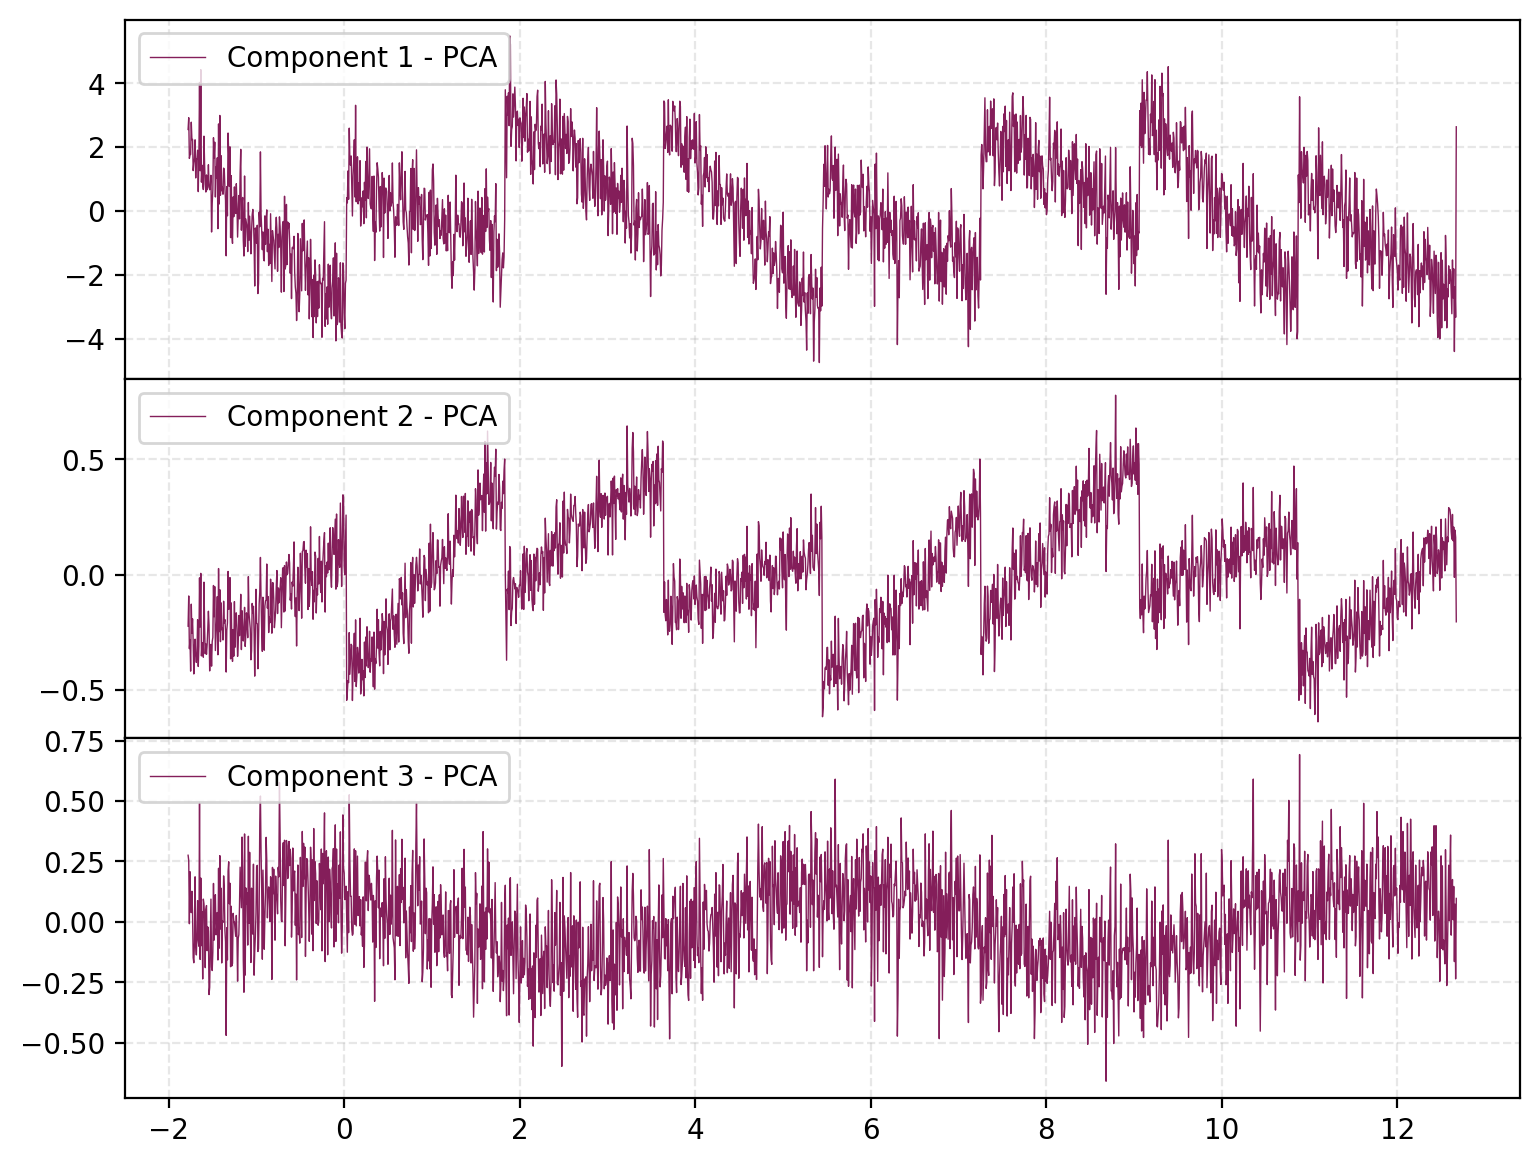

In [42]:
fig, ax = plt.subplots(3,1, figsize=(9,7), sharex=True)
fig.subplots_adjust(hspace=0.)

plt.subplot(311)
plt.plot(time, X_pca[:,0], label='Component 1 - PCA', color=c[1], lw=0.5)

plt.subplot(312)
plt.plot(time, X_pca[:,1], label='Component 2 - PCA', color=c[1], lw=0.5)

plt.subplot(313)
plt.plot(time, X_pca[:,2], label='Component 3 - PCA', color=c[1], lw=0.5)

for _ in ax:
    _.legend(frameon=True, loc='upper left')
    _.grid(True, ls='--', alpha=0.3)

It looks like **PCA** is capturing something in the signal but that doesn't seem like a great result. 
If we can assume that the background noise and the *Cepheid* signal are independent, which is quite reasonable, let's try to apply **ICA** instead.

In [7]:
from sklearn.decomposition import FastICA

ica = FastICA(n_components=3) 
ica.fit(std_X)

proj = ica.transform(std_X) # projection of the data: This reconstructs the signal using the two components ICA computed
comp = ica.components_

/home/nicolofiaba/.local/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


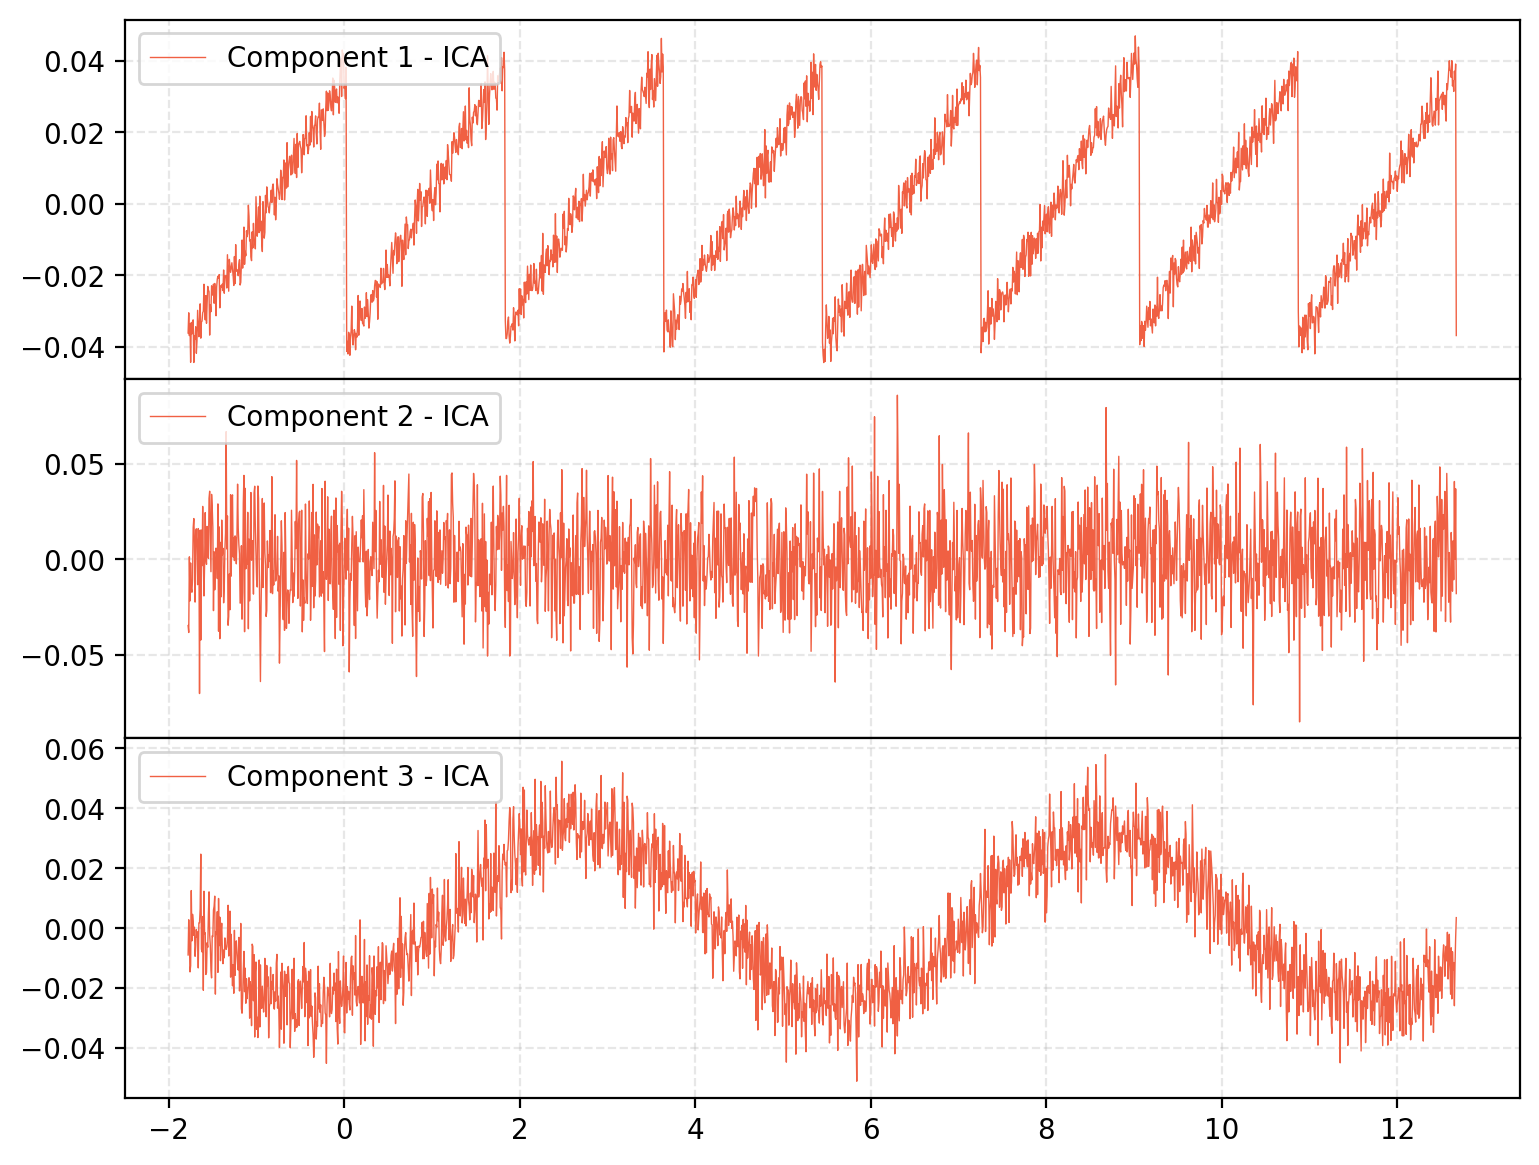

In [8]:
fig, ax = plt.subplots(3,1, figsize=(9,7), sharex=True)
fig.subplots_adjust(hspace=0.)
plt.subplot(311)

plt.plot(time, proj[:,0], label='Component 1 - ICA', color=c[3], lw=0.5)
plt.subplot(312)
plt.plot(time, proj[:,1], label='Component 2 - ICA', color=c[3], lw=0.5)
plt.subplot(313)
plt.plot(time, proj[:,2], label='Component 3 - ICA', color=c[3], lw=0.5)

for _ in ax:
    _.legend(frameon=True, loc='upper left')
    _.grid(True, ls='--', alpha=0.3)

Now the last component is clearly the periodic *Cepheid* signal we were looking for! We can fit it with a sinusoidal function to recover the **period**.

The estimated period of the Cepheid source is: 5.97617 +/- 0.00037 seconds


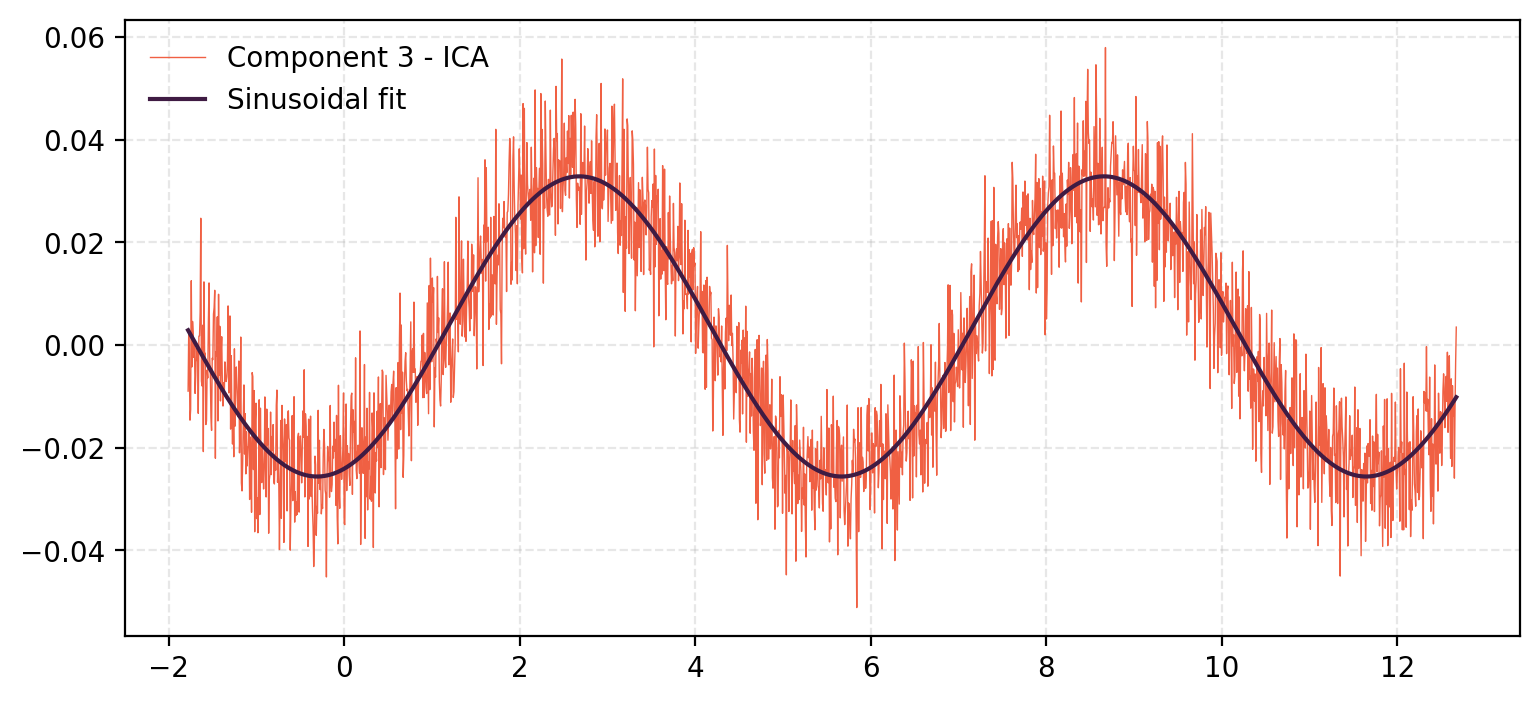

In [9]:
from scipy.optimize import curve_fit

def sinusoidal(x, A, f, phi, B):
    return A * np.sin(2 * np.pi * f * x + phi) + B

popt, pcov = curve_fit(sinusoidal, time, proj[:,2], p0=(0.04, 1/6, 1, 0.02))

fig = plt.figure(figsize=(9,4))
plt.plot(time, proj[:,2], label='Component 3 - ICA', color=c[3], lw=0.5)
plt.plot(time, sinusoidal(time, *popt), color=c[0], label='Sinusoidal fit')
plt.legend(frameon=False)
print("The estimated period of the Cepheid source is: %.5f +/- %.5f seconds"%(1/popt[1], np.sqrt(pcov[1,1])))

plt.grid(True, ls='--', alpha=0.3)